### They are all equally spaced

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.animation import FuncAnimation

In [2]:
########################################                 Define constants                   #############################################
N = 70
fixed_lam   = 1
fixed_gamma = 1

fixed_dist  = 0.3 * fixed_lam
fixed_phi   = 0

x_0      = 0.2
x_max    = 0.6
x_size   = 1

phi_0    = 0
phi_max  = 2 * np.pi / N
phi_size = 50

t_max    = 40
t_size   = 100
########################################################################################################################    
times  = np.linspace(0, t_max, t_size) * fixed_gamma
dists  = np.linspace(x_0, x_max, x_size) * fixed_lam
phis   = np.linspace(phi_0, phi_max, phi_size)

[[ 0.   0.   0. ]
 [ 0.3  0.   0. ]
 [ 0.6  0.   0. ]
 [ 0.9  0.   0. ]
 [ 1.2  0.   0. ]
 [ 1.5  0.   0. ]
 [ 1.8  0.   0. ]
 [ 2.1  0.   0. ]
 [ 2.4  0.   0. ]
 [ 2.7  0.   0. ]
 [ 3.   0.   0. ]
 [ 3.3  0.   0. ]
 [ 3.6  0.   0. ]
 [ 3.9  0.   0. ]
 [ 4.2  0.   0. ]
 [ 4.5  0.   0. ]
 [ 4.8  0.   0. ]
 [ 5.1  0.   0. ]
 [ 5.4  0.   0. ]
 [ 5.7  0.   0. ]
 [ 6.   0.   0. ]
 [ 6.3  0.   0. ]
 [ 6.6  0.   0. ]
 [ 6.9  0.   0. ]
 [ 7.2  0.   0. ]
 [ 7.5  0.   0. ]
 [ 7.8  0.   0. ]
 [ 8.1  0.   0. ]
 [ 8.4  0.   0. ]
 [ 8.7  0.   0. ]
 [ 9.   0.   0. ]
 [ 9.3  0.   0. ]
 [ 9.6  0.   0. ]
 [ 9.9  0.   0. ]
 [10.2  0.   0. ]
 [10.5  0.   0. ]
 [10.8  0.   0. ]
 [11.1  0.   0. ]
 [11.4  0.   0. ]
 [11.7  0.   0. ]
 [12.   0.   0. ]
 [12.3  0.   0. ]
 [12.6  0.   0. ]
 [12.9  0.   0. ]
 [13.2  0.   0. ]
 [13.5  0.   0. ]
 [13.8  0.   0. ]
 [14.1  0.   0. ]
 [14.4  0.   0. ]
 [14.7  0.   0. ]
 [15.   0.   0. ]
 [15.3  0.   0. ]
 [15.6  0.   0. ]
 [15.9  0.   0. ]
 [16.2  0.   0. ]
 [16.5  0.

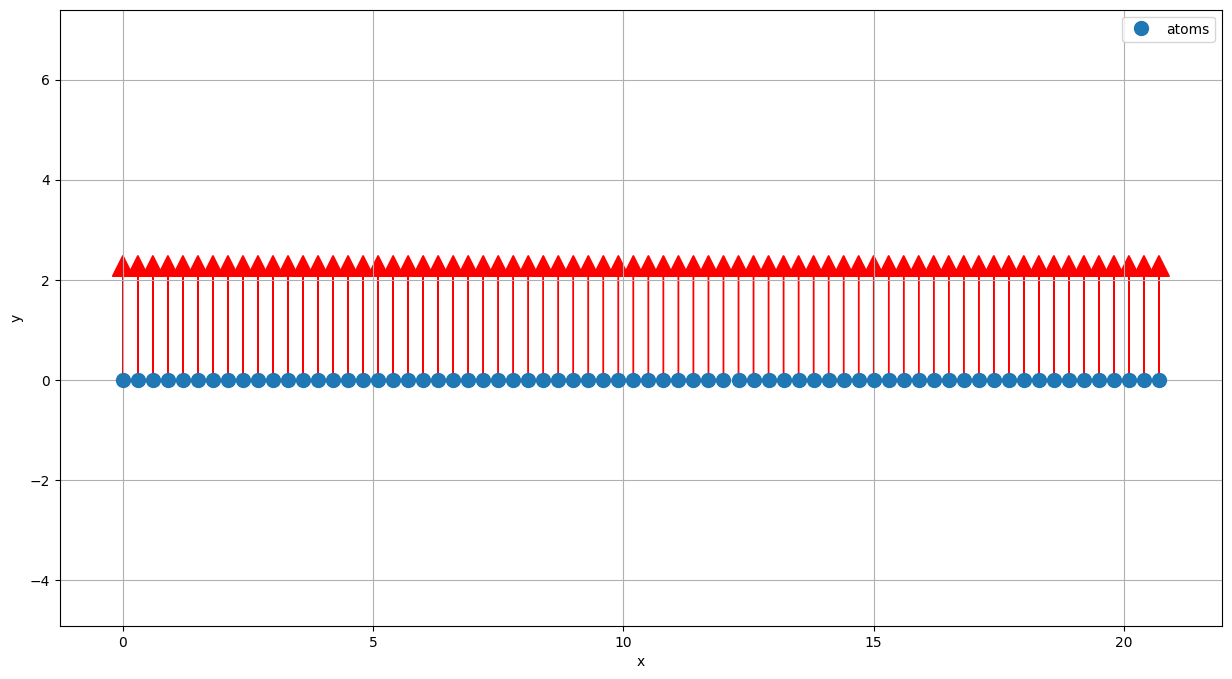

In [3]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = fixed_phi):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole

d_hats = np.array([np.array([0, 1,0]) for _ in range(N)])
def chain_positions(distance = fixed_dist, N = N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i,0] = i * distance
    return Pos

positions = chain_positions()
print(positions)

# Find the highest x_value
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
for i, position in enumerate(positions):
    ax.arrow(position[0], position[1], d_hats[i][0] * scale, d_hats[i][1] * scale, 
             head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True)
ax.legend()
ax.axis('equal')
plt.show()

In [4]:
########################################             create the Hamiltonean                 #################################################
#jetzt direkter weg zur NxN matrix mit Greentensor
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    Greenstensor = (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))
    return Greenstensor

def Gamma_coefficients(r_a, r_b,
                       d_a = dipole_vector(), 
                       d_b = dipole_vector(),
                       lam = fixed_lam,
                       gamma = fixed_gamma) -> float:

    if np.linalg.norm(r_b - r_a) < 1e-5:
        return gamma
    k_a = 2 * np.pi / lam
    result = (6 * np.pi * gamma / k_a  # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.imag(result)

def V_coefficients(r_a, r_b,
                   d_a = dipole_vector(), 
                   d_b = dipole_vector(),
                   lam = fixed_lam,
                   gamma = fixed_gamma) -> float:
    
    if np.linalg.norm(r_b - r_a) < 1e-5:
        return 0
    k_a = 2 * np.pi / lam
    result = (-3 * np.pi * gamma / k_a # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.real(result)

def H_eff(distance = fixed_dist, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma, N=N):
    positions = chain_positions(distance, N)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a = positions[a]
            r_b = positions[b]
            V_ab = V_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            Gamma_ab = Gamma_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            matrix_element = V_ab - 1j * 0.5 * Gamma_ab
            H_eff_matrix[a, b] = matrix_element
    return Qobj(H_eff_matrix)

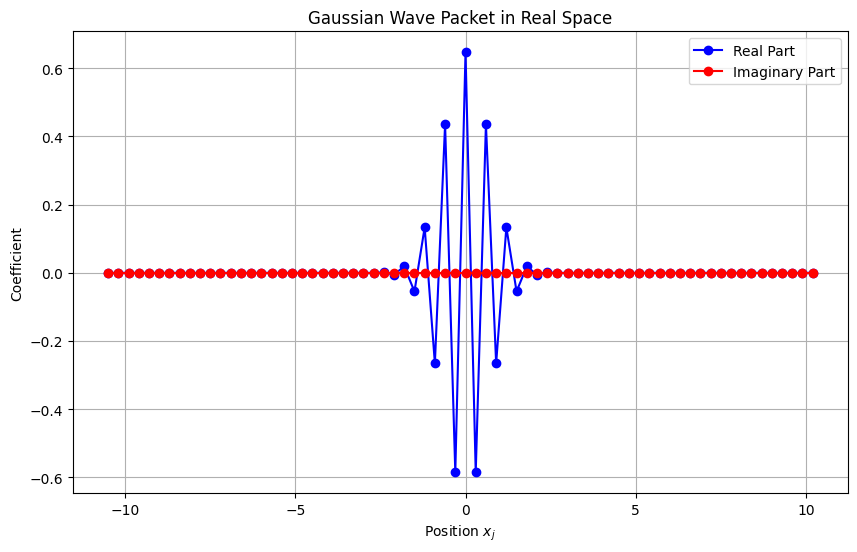

Quantum object: dims=[[70], [1]], shape=(70, 1), type='ket', dtype=Dense
Qobj data =
[[-1.55664480e-53]
 [ 1.41171389e-50]
 [-1.05093912e-47]
 [ 6.42217495e-45]
 [-3.22151689e-42]
 [ 1.32651571e-39]
 [-4.48371591e-37]
 [ 1.24404899e-34]
 [-2.83341759e-32]
 [ 5.29733444e-30]
 [-8.12976337e-28]
 [ 1.02417017e-25]
 [-1.05910751e-23]
 [ 8.99045505e-22]
 [-6.26465282e-20]
 [ 3.58332374e-18]
 [-1.68247567e-16]
 [ 6.48463061e-15]
 [-2.05161279e-13]
 [ 5.32818454e-12]
 [-1.13589143e-10]
 [ 1.98777899e-09]
 [-2.85544023e-08]
 [ 3.36706698e-07]
 [-3.25914846e-06]
 [ 2.58958540e-05]
 [-1.68900150e-04]
 [ 9.04281279e-04]
 [-3.97420943e-03]
 [ 1.43374417e-02]
 [-4.24586601e-02]
 [ 1.03213050e-01]
 [-2.05957040e-01]
 [ 3.37359060e-01]
 [-4.53609164e-01]
 [ 5.00662389e-01]
 [-4.53609164e-01]
 [ 3.37359060e-01]
 [-2.05957040e-01]
 [ 1.03213050e-01]
 [-4.24586601e-02]
 [ 1.43374417e-02]
 [-3.97420943e-03]
 [ 9.04281279e-04]
 [-1.68900150e-04]
 [ 2.58958540e-05]
 [-3.25914846e-06]
 [ 3.36706698e-07]
 [-

In [5]:
################ TRY to get the Wave-packet
k_s = np.pi / fixed_dist
sigma = 0.1 * k_s
kd_range = np.arange(0, N) * 2 * np.pi / (N * fixed_dist)
center_index = N // 2
x_j = (np.arange(N) - center_index) * fixed_dist

# Calculate the Gaussian wave packet in real space
coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
psi0 = wave_packet.unit()
# Plot the real and imaginary parts of the wave packet coefficients
plt.figure(figsize=(10, 6))
plt.plot(x_j, coefficients.real, 'bo-', label='Real Part')
plt.plot(x_j, coefficients.imag, 'ro-', label='Imaginary Part')
plt.xlabel('Position $x_j$')
plt.ylabel('Coefficient')
plt.title('Gaussian Wave Packet in Real Space')
plt.legend()
plt.grid(True)
plt.show()
#psi0=basis(N, 0)
psi0

In [6]:
#
# This doesnt make sense
#
def fidelity(psi_0, H, times):
    rho_0 = psi_0 * psi_0.dag()
    result = mesolve(H, rho_0, times, [], [])

    fidelities = []
    for rho_t in result.states:
        sqrt_rho0 = rho_0.sqrtm()
        product = sqrt_rho0 * rho_t * sqrt_rho0
        sqrt_product = product.sqrtm()

        trace_sqrt_product = sqrt_product.tr()
        fidelity = np.abs(trace_sqrt_product)**2

        fidelities.append(fidelity)

    return fidelities
x = fidelity(psi0, H, times)
plt.figure(figsize=(10, 6))
plt.plot(times, x, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.title('Fidelity')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'H' is not defined

In [8]:
from scipy.optimize import minimize
def survival_probabilities(dipoles, times, distance = fixed_dist, gamma=fixed_gamma, Psi_0=basis(N, N//2)):
    H = H_eff(distance = distance, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    coeffs_sq_mods  = np.zeros((len(times), N))
    P_surs  = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2

        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()

    return coeffs_sq_mods, P_surs

def optimization_target(dist):
    dist = dist[0]
    _, res = survival_probabilities(d_hats, [times[t_size//2]], distance=dist)
    return -res[0]

def positive_distance_constraint(params):
    distance = params[-1]
    return distance - 0.235 * fixed_lam
initial_distance = 0.235 * fixed_lam  # Initial guess for the distance
constraints = [{'type': 'ineq', 'fun': positive_distance_constraint}]
result = minimize(optimization_target, initial_distance, constraints=constraints, method='SLSQP', options={'maxiter': 1000}) #

optimized_distance = result.x[0]
print(optimized_distance)
y1, y2 = survival_probabilities(d_hats, times, distance=optimized_distance, Psi_0=psi0)

0.235


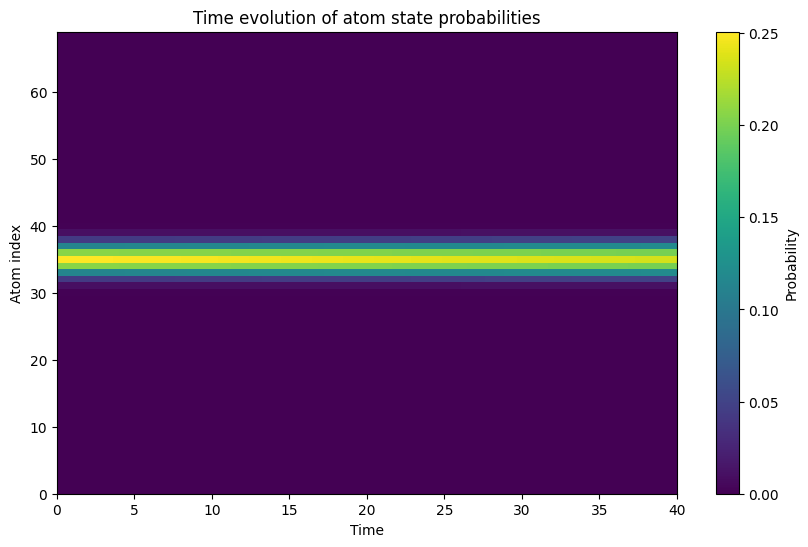

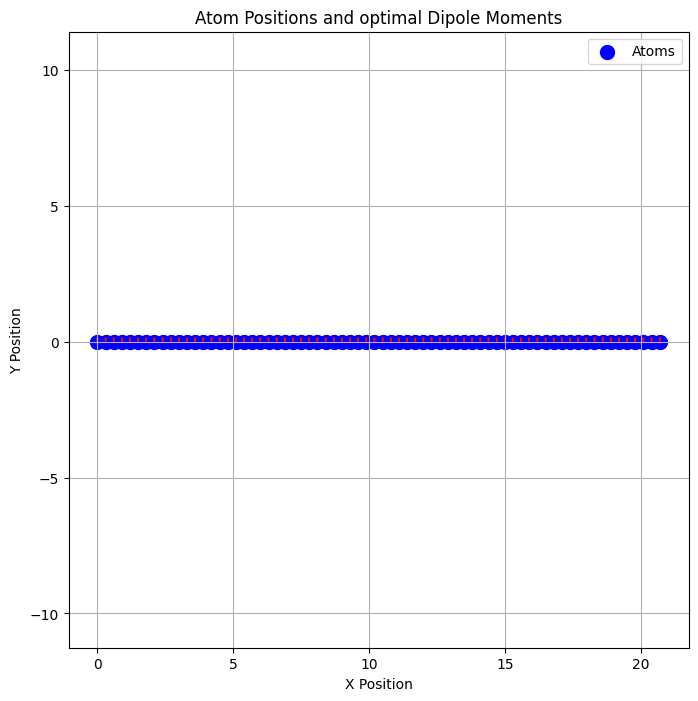

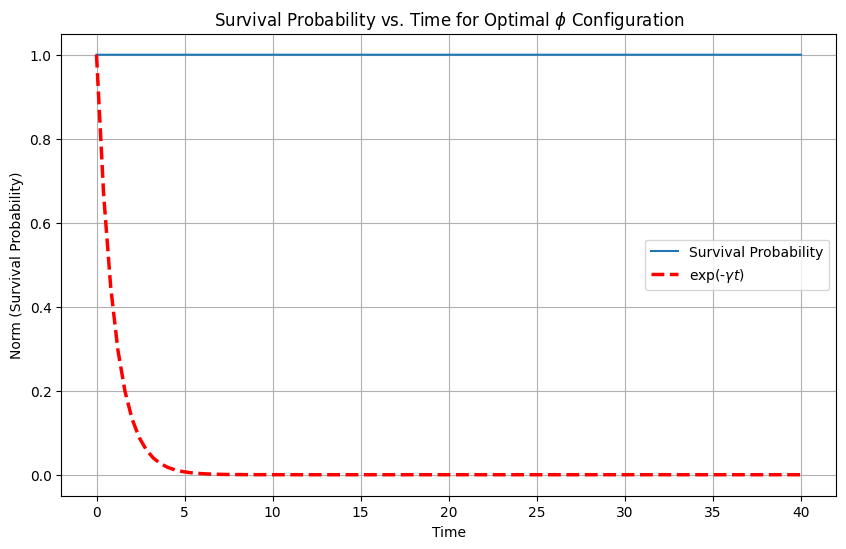

In [9]:
plt.figure(figsize=(10, 6))
plt.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index')
plt.title('Time evolution of atom state probabilities')
plt.show()
# Plot atoms with their dipole moments
positions = chain_positions(fixed_dist, N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], d_hats[i][0] * 0.1, d_hats[i][1] * 0.1, head_width=0.5 * 0.1, head_length=0.5 * 0.1, fc='red', ec='red')
plt.title('Atom Positions and optimal Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

# Plot the norms against time
plt.figure(figsize=(10, 6))
plt.plot(times, y2, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Optimal $\phi$ Configuration')
plt.legend()
plt.grid(True)
plt.show()

# old implementation

In [ ]:
#############################################---------        N x N case           ---------###########################################################

In [ ]:
H_red_list = reduced_H(H_list)
print('NxN H_eff:', H_red_list[0])

#Psi_01 = generic_superposition([basis(N, i) for i in range(N-1)])
Psi_01 = (basis(N,0)-basis(N,1)).unit() # only one atom is excited
print('Psi(0):', Psi_01)
norms = calculate_norms(x_vals, t_vals, H_red_list, Psi_01)

In [ ]:
plt.figure(figsize=(15, 5))
for i, x in enumerate(x_vals):
    plt.plot(t_vals, norms[i], label=f'x={x:.2f}')

plt.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')

# Final plot adjustments
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
plt.title('H is N x N; for symmetric distance values')
#plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
line, = ax.plot([], [], lw=2)
exp_line, = ax.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax.set_xlabel(r'$\gamma t$')
ax.set_ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
ax.set_title('H is N x N; for symmetric distance values')
ax.legend()

def init():
    line.set_data([], [])
    return line, exp_line

def update(frame):
    x = x_vals[frame]
    norm = norms[frame]
    line.set_data(t_vals, norm)
    line.set_label(f'x={x:.2f}')
    ax.legend()
    return line, exp_line

ani = FuncAnimation(fig, update, frames=len(x_vals), init_func=init, blit=True, repeat=False)
ani.save('N_.mp4', writer='ffmpeg')
plt.show()

In [ ]:
# Extract the phase of the off-diagonal elements. this code only makes sense for symmetric distances
# H_12 = V_12 - i / 2 G_12 == R * exp(i phi(x))
# also for H_13, H_230
# plot phi(distances)
H_list = [effective_hamiltonian(d_hat, gamma, dist, N) for dist in x_vals]
H_red_list = reduced_H(H_list)

# Calculate the phases for the off-diagonal elements
phases_12 = [np.angle(H[0, 1]) / np.pi for H in H_red_list]
phases_13 = [np.angle(H[0, 2]) / np.pi for H in H_red_list]
phases_23 = [np.angle(H[1, 2]) / np.pi for H in H_red_list]

# Plotting the phases   
plt.figure(figsize=(15, 5))
plt.plot(x_vals, phases_12, label=r'$H_{12}$')
plt.plot(x_vals, phases_13, label=r'$H_{31}$') #its the same as 12

plt.xlabel(r'Distance x / $\lambda_0$')
plt.ylabel(r'Phase / $\pi$')
plt.title('Phase of off-diagonal entries of H over distances')
plt.legend()
plt.savefig('phase_plot.png', dpi=300)  
plt.show()

## It does matter whether or not I reduce the Hamiltonean!!

In [ ]:
#############################################---------      2^N x 2^N case         ----------##################################################

In [ ]:
#### x = lambda / 2 case:
x_special = 0.5
x_vals_ = np.concatenate((x_vals[[0, int(x_size/2), -1]], np.array([x_special])))

print(f'2^{N} x 2^{N} H_eff: ', H_list[0])

single_exc_basis = single_excitation_basis(N)
#Psi_0 = generic_superposition(single_exc_basis)
Psi_0 = (single_exc_basis[N-1] + single_exc_basis[N-2]).unit()  # only the first atom is excited
print('Psi(0):', Psi_0)

norms = calculate_norms(x_vals, t_vals, H_list, Psi_0)

In [ ]:
plt.figure(figsize=(15, 5))
for i, x in enumerate(x_vals):
    plt.plot(t_vals, norms[i], label=f'x={x:.2f}')

plt.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')

# Final plot adjustments
plt.xlabel(r'$\gamma t$')
plt.ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
plt.title('H is2^N x 2^N; for symmetric distance values')
#plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
line, = ax.plot([], [], lw=2)
exp_line, = ax.plot(t_vals, np.exp(-t_vals), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax.set_xlabel(r'$\gamma t$')
ax.set_ylabel(r'$P_{sur(t)} = < \Psi_t | \Psi_t >$')
ax.set_title('H is 2^N x 2^N; for symmetric distance values')
ax.legend()

def init():
    line.set_data([], [])
    return line, exp_line

def update(frame):
    x = x_vals[frame]
    norm = norms[frame]
    line.set_data(t_vals, norm)
    line.set_label(f'x={x:.2f}')
    ax.legend()
    return line, exp_line

ani = FuncAnimation(fig, update, frames=len(x_vals), init_func=init, blit=True, repeat=False)
ani.save('N_sq.mp4', writer='ffmpeg')
plt.show()